In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

### **Loading the dataset**

In [9]:
def load_dataset():
    train_dataset = h5py.File('/home/yeabsira/Documents/Deep Learning Specialization study materials/Logistic Regression/datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/home/yeabsira/Documents/Deep Learning Specialization study materials/Logistic Regression/datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [53]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset() 

Each line of the training and testing sets of X are arrays representing an image

In [54]:
test_set_x_orig[0][1][:16]

array([[158, 103,  82],
       [160, 104,  82],
       [162, 105,  83],
       [163, 106,  83],
       [163, 106,  84],
       [161, 105,  84],
       [162, 106,  85],
       [165, 108,  86],
       [163, 109,  87],
       [159, 110,  90],
       [158, 111,  91],
       [162, 111,  90],
       [168, 113,  92],
       [167, 114,  93],
       [166, 114,  92],
       [170, 115,  94]], dtype=uint8)

y = 0, it's a 'non-cat' picture.


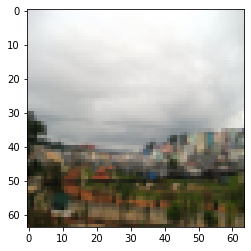

In [55]:
#Example of a picture

index = 17
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")

In [56]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [57]:
print("Number of training examples: ", train_set_x_orig.shape[0])
print("Number of testing examples: ", test_set_x_orig.shape[0])
print(f"Image Height: {train_set_x_orig.shape[1]} \nImage Width: {train_set_x_orig.shape[2]}")
print("Each image is of size: ", train_set_x_orig.shape[1:])
print("train_set_x shape: ", train_set_x_orig.shape)
print("train_set_y shape: ", train_set_y_orig.shape)
print("test_set_x shape: ", test_set_x_orig.shape)
print("test_set_y shape: ", test_set_y.shape)

Number of training examples:  209
Number of testing examples:  50
Image Height: 64 
Image Width: 64
Each image is of size:  (64, 64, 3)
train_set_x shape:  (209, 64, 64, 3)
train_set_y shape:  (1, 209)
test_set_x shape:  (50, 64, 64, 3)
test_set_y shape:  (1, 50)


## **Data Preprocessing**

### Flattening the array data

In [58]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1] * test_set_x_orig.shape[2] * test_set_x_orig.shape[3], test_set_x_orig.shape[0])

In [61]:
print ("train_set_x_flatten shape: ", train_set_x_flatten.shape)
print ("train_set_y shape: ", train_set_y.shape)
print ("test_set_x_flatten shape: ", test_set_x_flatten.shape)
print ("test_set_y shape: ", test_set_y.shape)
print ("sanity check after reshaping: ", train_set_x_flatten[0:5,0])

train_set_x_flatten shape:  (12288, 209)
train_set_y shape:  (1, 209)
test_set_x_flatten shape:  (12288, 50)
test_set_y shape:  (1, 50)
sanity check after reshaping:  [17 31 56 22 33]


>**Standardizing the dataset**

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [69]:
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

## **Building algorithms for the Model**

In building a Neural Network the main steps are to:
    1. Define the model structure (such as number of input features)
    2. Initialize the model's parameters
    3. Loop through to:
        * Calculate current loss (forward propagation)
        * Calculate current gradient (backward propagation)
        * Update parameters (gradient descent)
        
>**Integrating the above steps into one function will give birth to our model()**

In [70]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    
    Arguments:
    z -> A scalar or numpy array of any size.
    
    Return:
    s -> sigmoid(z)
    """
    
    s = 1 / (1 + np.exp(-z))
    
    return s

In [71]:
def initialize_with_zeros(dim):
    """
     This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -> size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -> initialized vector of shape (dim, 1)
    b -> initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [72]:
dim=3
w, b = initialize_with_zeros(dim)
print ('w = ', w)
print('b = ', b)

w =  [[0.]
 [0.]
 [0.]]
b =  0


Creating the forward and backward propagation steps to learn the parameters

In [76]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient
    
    Arguments:
    w -> weights, a numpy array of size (num_px * num_px * 3, 1)
    b -> bias, a scalar
    X -> data of size (num_px * num_px * 3, number of examples)
    Y -> true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -> negative log-likelihood cost for logistic regression
    dw -> gradient of the loss with respect to w, thus same shape as w
    db -> gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1] #number of observations
    
    # Forward propagation (from X to Cost)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(((-np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m
    
    # Backward propagation (To find the gradient descent)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape ==())
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [77]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = ", grads["dw"])
print ("db = ", grads["db"])
print ("cost = ",cost)

dw =  [[0.99845601]
 [2.39507239]]
db =  0.001455578136784208
cost =  5.801545319394553


Defining optimization function to update the weight (w) and bias (b) parameters with respect to the minimization of the cost function.

In [81]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -> weights, a numpy array of size (num_px * num_px * 3, 1)
    b -> bias, a scalar
    X -> data of shape (num_px * num_px * 3, number of examples)
    Y -> true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -> number of iterations of the optimization loop
    learning_rate -> learning rate of the gradient descent update rule
    print_cost -> True to print the loss every 100 steps
    
    Returns:
    params -> dictionary containing the weights w and bias b
    grads -> dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -> list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        # Calculating gradient and cost
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieving the derivatives with respect to w and b form grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Updating the weight and bias values
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        
        # Storing the cost values every 100 iterations
        if i % 100 == 0:
            costs.append(cost)
            
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w": w, "b": b}
    
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [82]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = ", params["w"])
print ("b = ", params["b"])
print ("dw = ", grads["dw"])
print ("db = ", grads["db"])

w =  [[0.19033591]
 [0.12259159]]
b =  1.9253598300845747
dw =  [[0.67752042]
 [1.41625495]]
db =  0.21919450454067654


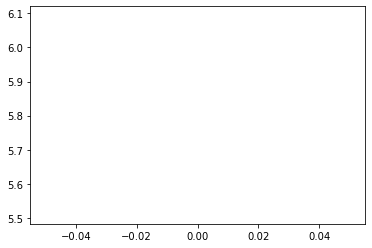

In [86]:
plt.plot(costs)

Defining predicting function

In [91]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -> weights, a numpy array of size (num_px * num_px * 3, 1)
    b -> bias, a scalar
    X -> data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -> a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = X.shape[1]
    y_pred = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T,X) + b)
    
    y_pred = (A >= 0.5) * 1.0
    
    assert(y_pred.shape == (1, m))
    
    return y_pred

In [93]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = ", np.squeeze(predict(w, b, X)))

predictions =  [1. 1. 0.]


## **Merging all functions to construct the model**

In [119]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -> training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -> training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -> test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -> test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -> hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -> hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -> Set to true to print the cost every 100 iterations
    
    Returns:
    d -> dictionary containing information about the model.
    """
    
    # Initializing parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Calculating for the gradient descent and performing optimization on the weight and bias
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieving parameters for predicton
    w = parameters["w"]
    b = parameters["b"]
    
    # Predicting both for the training and testing sets
    pred_train = predict(w, b, X_train)
    pred_test = predict(w, b, X_test)
    
    # Calculating the training and testing predictions accuracy using MAE
    train_acc = f"{100 - np.mean(np.abs(pred_train - Y_train)) * 100} %"
    test_acc = f"{100 - np.mean(np.abs(pred_test - Y_test)) * 100} %"
    
    # Construct a dictionary that holds the parameters, predicted values and costs
    result = {
        "Train Accuracy" : train_acc,
        "Test Accuracy" : test_acc,
        "Learning Rate" : learning_rate,
        "Number of Iterations" : num_iterations,
        "Train Prediction" : pred_train,
        "Test Prediction" : pred_test,
        "Costs" : costs,
        "Weight" : w,
        "Bias" : b,
        
    }
    
    return result

In [120]:
results = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

In [121]:
results

{'Train Accuracy': '99.04306220095694 %',
 'Test Accuracy': '66.0 %',
 'Learning Rate': 0.005,
 'Number of Iterations': 2000,
 'Train Prediction': array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
         1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
         0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.